## High-frequency-trading algorithm for automated market-making

This notebook implements a trading algorithm for automated market making. The model is specifically designed to work the limit orders at the best bid and offer only. 

### Business Logic:

The algrithm analyzes the order flow and orderbook and decides whether it should provide liquidity to the market. The internal decision making of the algorithm is based on dynamic programming principle for solving stochastic optimal control problem. At each time point $t$ the algorithm seeks to make decisions that maximise its "utility" at some future time $T$.

In the context of trading the utility may be represented as net monetary gain which results from participating in the liquidity provision of securities. Mathematically, the algorithm seeks to optimize the following objective:

\begin{align}
H(t,x,S_t,q) = \mathbb{E} \left[ \text{Payoff at time T} - \text{Total costs } | \mathcal{F}  \right] 
= \mathbb{E} \left[ X_T + Q_T \left(S_T-\left(\Delta + \alpha Q_T\right)\right) - \phi \int_{0}^{T}Q_{s}^{2}ds | \mathcal{F}  \right]
\end{align}

where $X_T$ represents the accrued proceeds from trading, $Q_T(S_T-(\Delta + \alpha Q_T))$ represents the liquidation value of the existing inventory of securities and $- \phi \int_{0}^{T}Q_{s}^{2}ds$ represents the total accrued running costs.

## Model 

The model is comprised of several mathematical "components" which all contribute to the final decision making logic.

#### Cash
The cash generated by the algorithm evolves according to:

\begin{align*}
    dX_t = \left(S_t + \Delta^{+} \right)l^{+} p_{t}^{+}dN_t^{+} + \left(S_t + \Delta^{-} \right)l^{-} p_{t}^{-}dN_t^{-}
\end{align*}

where:
    
    TODO


## Model parameters

$\lambda^{-}$ = arrival rate for $\textbf{sell}$ market orders

$\lambda^{+}$ = arrival rate for $\textbf{buy}$ market orders

$\phi$ = running inventory penalty

$\alpha$ = terminal inventory penalty

$q_{max}$ = maximum long inventory

$q_{min}$ = maximum short inventory


## Numerical Example 1.: Balanced Order Flow

In the numerical example below the market order flow on at the offer exactly matches that on the bid. The graph below visualizes the optimal market making strategy in this particular scenario.

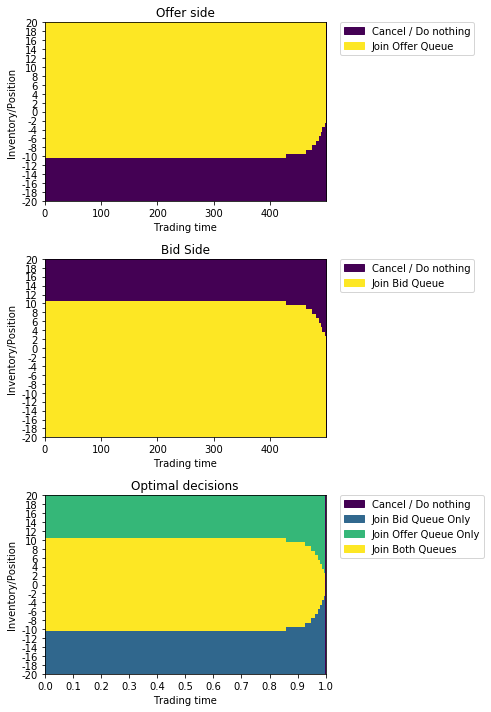

In [3]:
from src.hjb_solvers import MMATT_Model_Parameters
from src.hjb_solvers import MMATT_Finite_Difference_Solver
from src.plot_utils  import plot_decision_boundaries

lambda_m = 200     # Order-flow at the bid
lambda_p = 200     # Order-flow at the offer
alpha    = 0.001   # Terminal inventory penalty
phi      = 0.001   # Running inventory penalty
q_min    = -20     # Maximum short inventory
q_max    =  20     # Maximum long inventory
delta    = 0.01    # Average edge level per trade

# Encapsulate parameters
params = MMATT_Model_Parameters(lambda_m,lambda_p,delta,phi,alpha,q_min,q_max)

# Solve
result = MMATT_Finite_Difference_Solver.solve(params,500)

# Plot the decision boundaries
plot_decision_boundaries(result,(7,10))

## Numerical Example 2.: Imbalanced Order Flow

In the numerical example below the market order flow on at the offer is much smaller than that on the bid. The graph below visualizes the optimal market making strategy in this particular scenario.

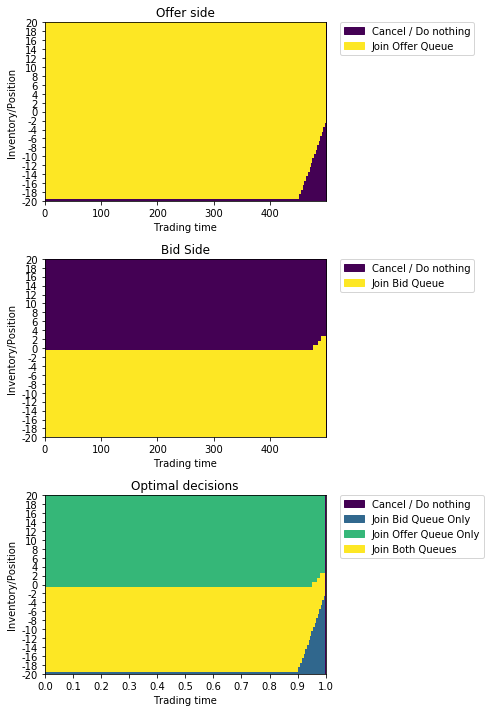

In [2]:
lambda_m = 200     # Order-flow at the bid
lambda_p = 20      # Order-flow at the offer
alpha    = 0.001   # Terminal inventory penalty
phi      = 0.001   # Running inventory penalty
q_min    = -20     # Maximum short inventory
q_max    =  20     # Maximum long inventory
delta    = 0.01    # Average edge level per trade

# Encapsulate parameters
params = MMATT_Model_Parameters(lambda_m,lambda_p,delta,phi,alpha,q_min,q_max)

# Solve
result = MMATT_Finite_Difference_Solver.solve(params,500)

# Plot the decision boundaries
plot_decision_boundaries(result,(7,10))